In [5011]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Data Processing and Visualization Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline

# models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# 1.Problem Definition
Predict the survival of a passenger in the sinking of the Titanic based on a set of variables describing their such as age, sex, or passenger class on the boat.
We are predicting for the target column - Survived. This is a binary classification problem. 

# 2.Data
There are two datasets available, a train set and a test set.
Data provided from Kaggle link: (https://www.kaggle.com/c/titanic/data)

# 3.Goal
To use the training set to build a predictive model and the testing set to validate that model. 

For each passenger in the test set, to predict whether or not they survived the sinking. 
The model score is the percentage of passengers correctly predict, known as accuracy.

In [5012]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5013]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5014]:
# Using info method to get quick overview of the data sets
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5015]:
# Shape of the training data set
train_data.shape

(891, 12)

In [5016]:
# Shape of testing data set
test_data.shape

(418, 11)

In [5017]:
# Descriptive Statistics
train_data.describe()

/opt/conda/lib/python3.6/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5018]:
# View missing data in training set
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5019]:
# Create table for missing data analysis
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
    return pd.concat([Total,Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

In [5020]:
# Run the above function to explore the missing values % for train_data 
find_missing_data(train_data)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


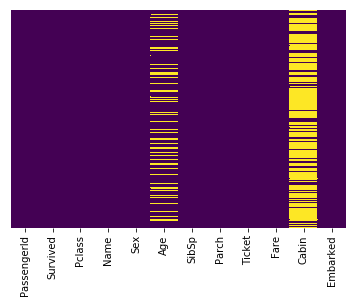

In [5021]:
# Visualization with heatmap for train_data
sns.heatmap(train_data.isna(), cbar = False , 
            yticklabels = False , cmap = 'viridis');

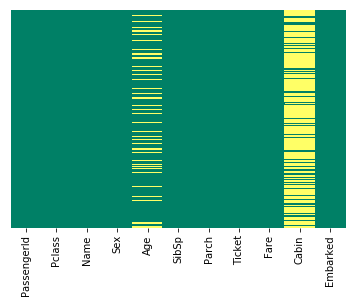

In [5022]:
# Visualization with heatmap for test_data
sns.heatmap(test_data.isna(), yticklabels = False,
            cbar = False, cmap = 'summer');

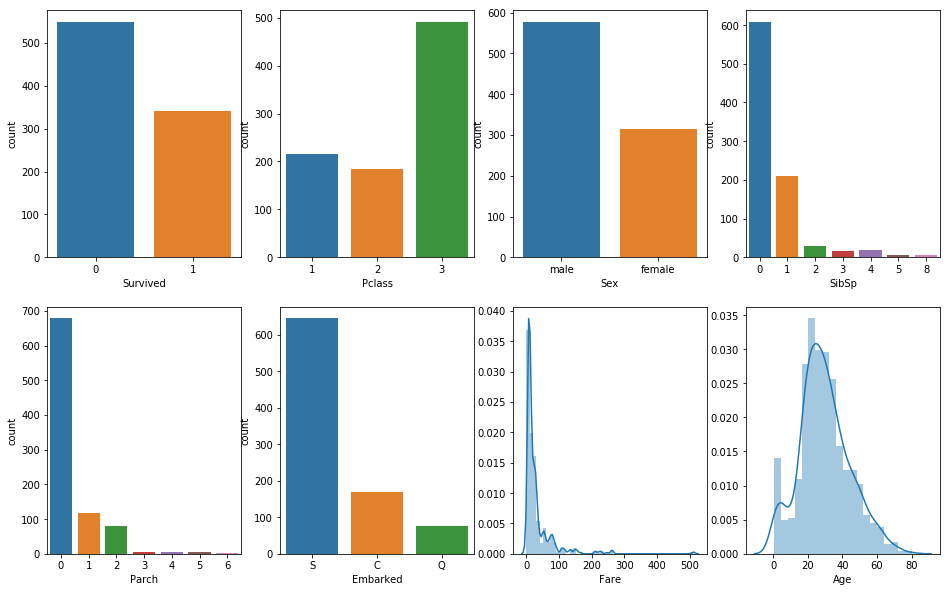

In [5023]:
# Univariate Analysis
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
sns.countplot('Survived',data=train_data,ax=axes[0,0])
sns.countplot('Pclass',data=train_data,ax=axes[0,1])
sns.countplot('Sex',data=train_data,ax=axes[0,2])
sns.countplot('SibSp',data=train_data,ax=axes[0,3])
sns.countplot('Parch',data=train_data,ax=axes[1,0])
sns.countplot('Embarked',data=train_data,ax=axes[1,1])
sns.distplot(train_data['Fare'], kde=True,ax=axes[1,2])
sns.distplot(train_data['Age'].dropna(),kde=True,ax=axes[1,3]);

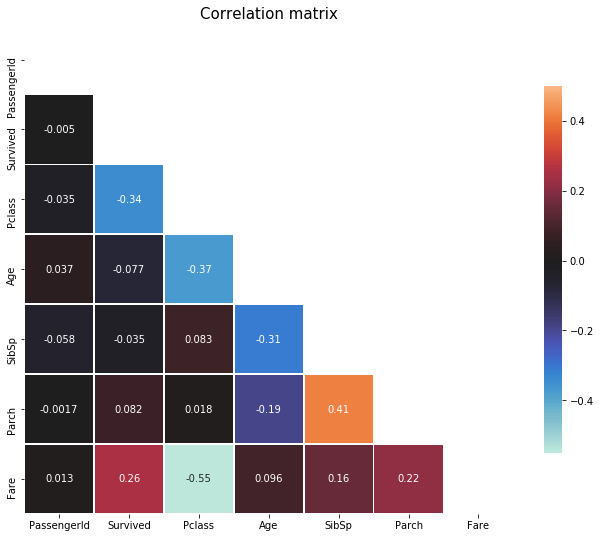

In [5024]:
# Correlation matrix : positve coorelation between Fare and Survived and a negative coorelation between Pclass and Surived
corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            mask=mask,
            annot=True,
            vmax=.5,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .75})
plt.title('Correlation matrix', fontsize = 15)
plt.show()

In [5025]:
# Correlation matrix : negative coorelation between Fare and Pclass, Age and Plcass
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [5026]:
train_data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5027]:
train_data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [5028]:
# Compare target column, survived with sex column
pd.crosstab(train_data.Survived, train_data.Sex)

Sex,female,male
Survived,,
0,81,468
1,233,109


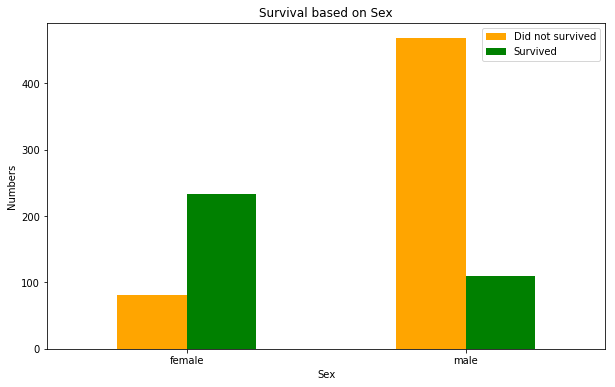

In [5029]:
# Compare target column, Survived with Sex column
pd.crosstab(train_data.Sex, train_data.Survived).plot(kind="bar",
                                                      figsize=(10,6),
                                                      color=["orange", "green"]);
plt.title("Survival based on Sex")
plt.ylabel("Numbers")
plt.legend(["Did not survived", "Survived"])
plt.xticks(rotation=0);

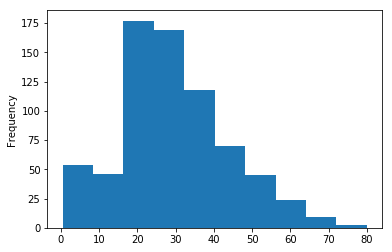

In [5030]:
train_data.Age.plot.hist();

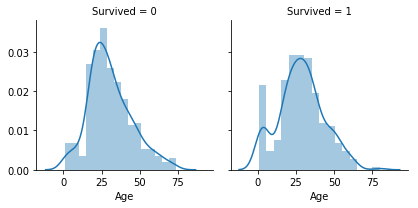

In [5031]:
# Visualise with FacetGrid on the Age vs Survived features
age_survived = sns.FacetGrid(train_data, col='Survived')
age_survived = age_survived.map(sns.distplot, "Age")

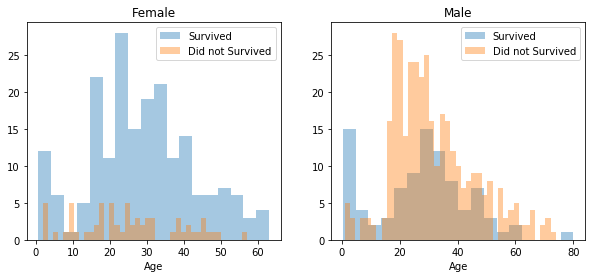

In [5032]:
# Age VS Sex: for certain ages, we can see a increase in the odds of survival
survived = 'Survived'
not_survived = 'Did not Survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male');

In [5033]:
# Compare target column with fare column
pd.crosstab(train_data.Fare, train_data.Survived)

Survived,0,1
Fare,,
0.0000,14,1
4.0125,1,0
5.0000,1,0
6.2375,1,0
6.4375,1,0
...,...,...
227.5250,1,3
247.5208,1,1
262.3750,0,2


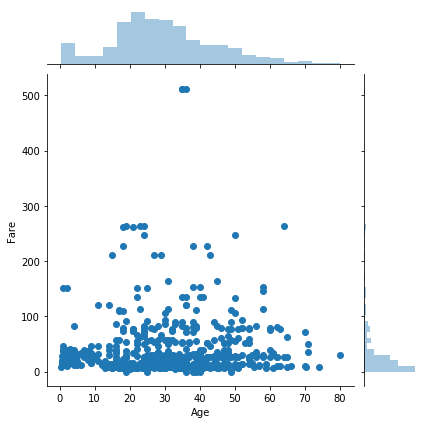

In [5034]:
# Joint Plots(Age continous vs Fare continous features)
sns.jointplot(x="Age", y="Fare", data=train_data);

In [5035]:
# Age VS Survived
train_data.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

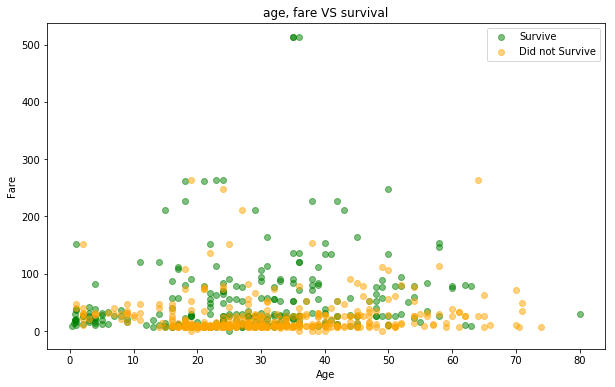

In [5036]:
# There are 88 lengths, which conveys different valies in the column, not good idea for bar graph.
# Use scatter graph to combine age, fare and survival in one chart
plt.figure(figsize=(10,6))

#scatter with Survived
plt.scatter(train_data.Age[train_data.Survived==1],
            train_data.Fare[train_data.Survived==1], 
            color="green", alpha=0.5);

#scatter with not Survived
plt.scatter(train_data.Age[train_data.Survived==0],
            train_data.Fare[train_data.Survived==0], 
            color="orange", alpha=0.5)

plt.title("age, fare VS survival")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.legend(["Survive", "Did not Survive"]);

# Below is a single chart which shows the age and fare correlation with survival. X-axis = Age ,Y-axis = Ticket_Fare ,green dots = Survived, orange dots= Did not Survive
# green dots between x=0 & x=10  : Children who were survived
# pink dots between x=10 & x=45  : Adults who died (from a lower classes)
# green dots between x=20 & x=45 : Adults with larger ticket fares who are survived.

In [5037]:
train_data.groupby(["Pclass"]).mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [5038]:
train_data.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


In [5039]:
Pclass_sex_grouping = train_data.groupby(['Pclass','Sex']).mean()
Pclass_sex_grouping

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

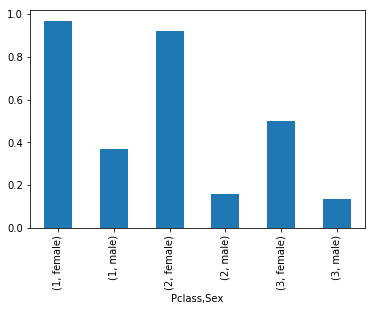

In [5040]:
Pclass_sex_grouping['Survived'].plot.bar();

# From EDA, 4 features may be useful in predicting Survival:
1. Sex
1. Age 
1. Name
1. Pclass

In [5041]:
# Drop Ticket and Cabin features as it does not add value to survival predictions and cabin has many missing values
train_data.drop(labels = ['Ticket','Cabin'], axis = 1, 
             inplace = True)
test_data.drop(labels = ['Ticket','Cabin'], axis = 1, 
             inplace = True)

In [5042]:
test_data.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

In [5043]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [5044]:
# Fill the "Fare" column
test_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)
test_data['Fare'] = test_data['Fare'].astype(int)

In [5045]:
train_data['Fare'] = train_data['Fare'].astype(int)

In [5046]:
# Fill the Embarked column
train_data["Embarked"].fillna("S", inplace=True)

In [5047]:
# Convert Embarked feature into numeric.
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [5048]:
test_data.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64

In [5049]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [5050]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null int64
Embarked       891 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 69.7+ KB


In [5051]:
# Convert Sex feature into numeric.
genders = {"male": 0, "female": 1}
data = [train_data, test_data]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

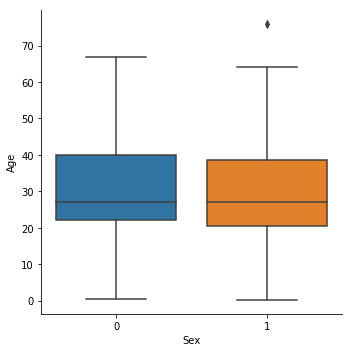

In [5052]:
# Age distribution seems to be almost same in Male and Female subpopulations, so Sex is not informative to predict Age, continue to explore further
Age_Sex = sns.catplot(y="Age", x="Sex", data = dataset, kind="box");

In [5053]:
train_data['Title'] = train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_data = train_data.drop(columns='Name')

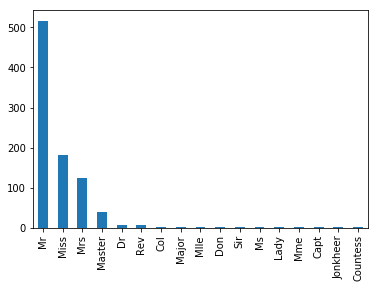

In [5054]:
train_data.Title.value_counts().plot(kind='bar');

In [5055]:
train_data['Title'] = train_data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')
train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')

# filling NaN with 0, to get safe
train_data['Title'] = train_data['Title'].fillna(0)

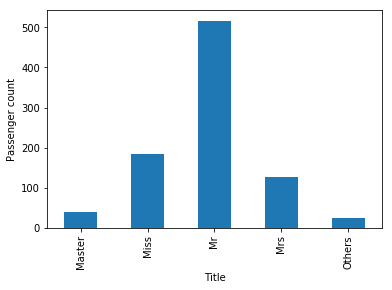

In [5056]:
plt = train_data.Title.value_counts().sort_index().plot(kind='bar')
plt.set_xlabel('Title')
plt.set_ylabel('Passenger count');

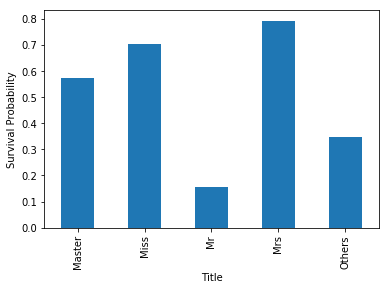

In [5057]:
plt = train_data[['Title', 'Survived']].groupby('Title').mean().Survived.plot(kind='bar')
plt.set_xlabel('Title')
plt.set_ylabel('Survival Probability');

In [5058]:
# Convert titles into numbers
train_data['Title'] = train_data['Title'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Others':4})

In [5059]:
# Convert to int64
train_data['Title'] = train_data['Title'].astype(int)

In [5060]:
train_data.groupby('Title')['Age'].mean()

Title
0     4.574167
1    21.845638
2    32.368090
3    35.788991
4    45.545455
Name: Age, dtype: float64

In [5061]:
# Assign the train_data NaN Values with values of the mean ages
train_data.loc[(train_data.Age.isnull())&(train_data.Title==2),'Age']=33
train_data.loc[(train_data.Age.isnull())&(train_data.Title==3),'Age']=36
train_data.loc[(train_data.Age.isnull())&(train_data.Title==0),'Age']=5
train_data.loc[(train_data.Age.isnull())&(train_data.Title==1),'Age']=22
train_data.loc[(train_data.Age.isnull())&(train_data.Title==4),'Age']=46

In [5062]:
# Convert Age from float64 to int64, using the “astype()” function pandas provides
train_data['Age'] = train_data['Age'].astype(int)

In [5063]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null int64
Embarked       891 non-null int64
Title          891 non-null int64
dtypes: int64(10)
memory usage: 69.7 KB


In [5064]:
test_data['Title'] = test_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_data = test_data.drop(columns='Name')

test_data['Title'] = test_data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
test_data['Title'] = test_data['Title'].replace('Ms', 'Miss')
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs')
test_data['Title'] = test_data['Title'].replace('Mlle', 'Miss')

test_data['Title'] = test_data['Title'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Others':4})

# filling NaN with 0, to get safe
test_data['Title'] = test_data['Title'].fillna(0)

In [5065]:
# Convert to int64
test_data['Title'] = test_data['Title'].astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
## Assigning the test_data NaN Values with values of the mean ages
test_data.loc[(test_data.Age.isnull())&(test_data.Title==2),'Age']=33
test_data.loc[(test_data.Age.isnull())&(test_data.Title==3),'Age']=36
test_data.loc[(test_data.Age.isnull())&(test_data.Title==0),'Age']=5
test_data.loc[(test_data.Age.isnull())&(test_data.Title==1),'Age']=22
test_data.loc[(test_data.Age.isnull())&(test_data.Title==4),'Age']=46

In [ ]:
# Convert test_data.Age from float64 to int64, using the “astype()” function pandas provides:
test_data['Age'] = test_data['Age'].astype(int)

In [ ]:
train_data.info()

In [ ]:
# title_mode = train_data.Title.mode()[0]
# test_data.Title = test_data.Title.fillna(title_mode)

In [ ]:
test_data.info()

In [ ]:
train_data.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")